In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

path = ""

In [2]:
# Basic Stuff
import pandas as pd
import numpy as np
from scipy import stats
from itertools import combinations

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

#ML
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Matplotlib parameters customization

fig_color = (150/255, 24/255, 24/255, 1)
fig_color_1 =  (232/255, 212/255, 84/255 ,1)
def set_mpl_params(COLOR = 'black'):  
  mpl.rcParams['text.color'] = COLOR
  mpl.rcParams['font.weight'] = 'normal'
  mpl.rcParams['figure.titleweight'] = 'normal'
  mpl.rcParams['axes.labelcolor'] = COLOR
  mpl.rcParams['axes.edgecolor'] = COLOR
  mpl.rcParams['xtick.color'] = COLOR
  mpl.rcParams['ytick.color'] = COLOR
  mpl.rcParams['figure.facecolor'] = (1,1,1,0)
  mpl.rcParams['savefig.facecolor'] = (0,0,0,0)
  mpl.rcParams['savefig.transparent'] = False

# Importing and cleaning the data

In [4]:
# Load Data and keep year from release date

factors = pd.read_csv(path + "../data/clustering/factor_assignment.csv")
topics = pd.read_csv(path + "../data/clustering/movie_topic_distribution.csv")

data = pd.read_csv(path + "../data/movie_data_imdbscores_final.csv").drop('plot_summary', axis = 1)


data = data.merge(factors, on = 'movie_id').merge(topics, on = 'movie_id').set_index('movie_id')

data.head()

,movie_name,release_date,english_language,german_language,silent_film_language,spanish_language,japanese_language,italian_language,tamil_language,hindi_language,...,F_gender,averageRating,numVotes,factor_1,factor_2,factor_3,topic_1,topic_2,topic_3,topic_4
movie_id,,,,,,,,,,,,,,,,,,,,,
975900,ghosts of mars,2001,True,False,False,False,False,False,False,False,...,0.352941,4.9,55254,0,1,0,0.103689,0.513649,0.076592,0.306070
9363483,white of the eye,1987,True,False,False,False,False,False,False,False,...,0.500000,6.1,2631,0,0,1,0.404839,0.087244,0.171197,0.336720
261236,a woman in flames,1983,False,True,False,False,False,False,False,False,...,0.333333,6.0,590,1,0,0,0.743302,0.006484,0.024737,0.225477
18998739,the sorcerer's apprentice,2002,True,False,False,False,False,False,False,False,...,0.200000,6.5,160,0,1,0,0.372719,0.212864,0.113500,0.300917
12621957,the sorcerer's apprentice,2010,True,False,False,False,False,False,False,False,...,0.312500,6.5,160,0,0,1,0.071356,0.247163,0.171496,0.509985


# Basic plotting and discretization of ratings

In [5]:
set_mpl_params('white')

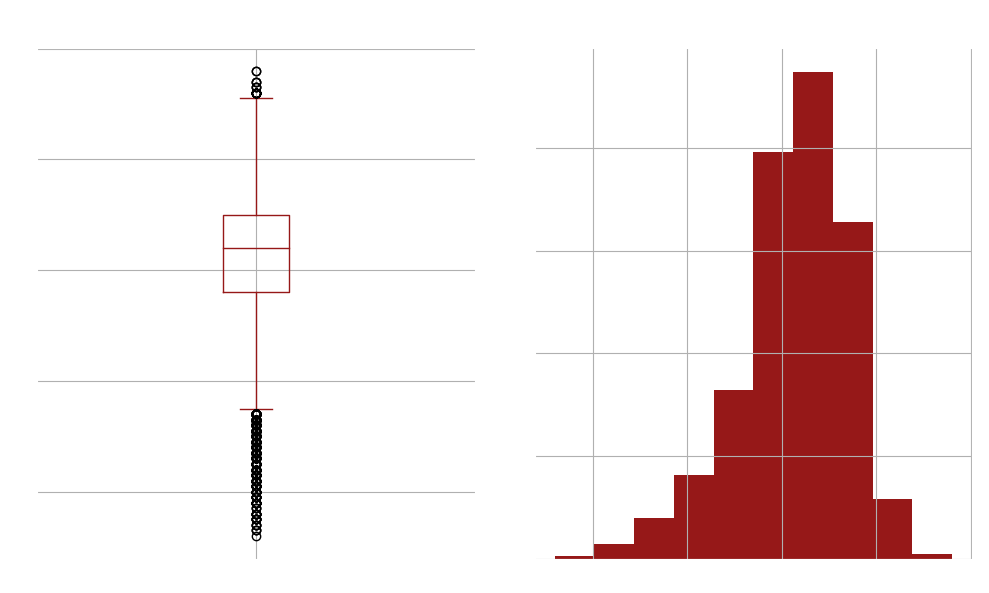

In [6]:
# Plot averageRating distribution

fig, ax = plt.subplots(1, 2, figsize = (10,6), dpi = 100)
ax = ax.flatten()
data.averageRating.plot.box(ax = ax[0], color= fig_color, grid = True)
data.averageRating.hist(ax = ax[1], color = fig_color)
fig.suptitle("averageRating distribution")
plt.tight_layout()
plt.savefig(path + '../figs/averageRating_distribution.png')
plt.show()

In [7]:
data.averageRating.describe()

count    31291.000000
mean         6.236113
std          1.164524
min          1.200000
25%          5.600000
50%          6.400000
75%          7.000000
max          9.600000
Name: averageRating, dtype: float64

In [8]:
# Discretize feature based on quantiles
def discretize_column(data, n, label_suffix = "_star"):
    
    # Compute proportion for quantile
    p = 1/(n)
    
    # Return semgments
    return pd.cut(data,
                  # Create interval cuts
                  bins = [np.quantile(data, x * p) if x != n else np.inf
                          for x in range(n+1)],
                  right = False,
                  # assign labels
                  labels = [f"{i+1}{label_suffix}" for i in range(n)])

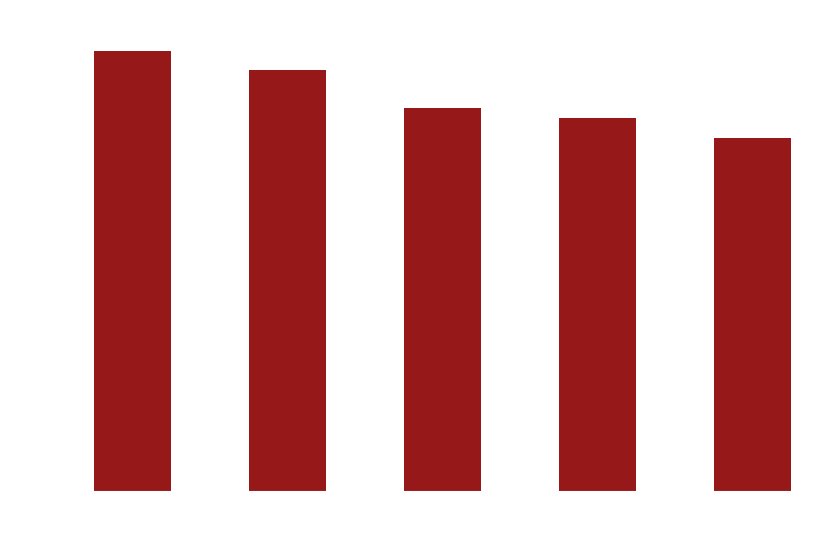

In [9]:
# Perform discretization and save categories in new feature
data["score_discretized"] = discretize_column(data.averageRating, 5)


plt.figure(figsize = (10,6), dpi = 100)
# Verify Discretization proportions
data.score_discretized.value_counts().plot.bar(color = fig_color)
plt.title("Number of movies per categories")
plt.savefig(path + '../figs/score_discretization_distribution.png')
plt.show()

In [10]:
# Compute mean proportions and means for numeric values
grouped = data.groupby('score_discretized')
grouped_means = grouped.mean()
grouped_means

/tmp/ipykernel_705227/3157792033.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_means = grouped.mean()


,release_date,english_language,german_language,silent_film_language,spanish_language,japanese_language,italian_language,tamil_language,hindi_language,malayalam_language,...,F_gender,averageRating,numVotes,factor_1,factor_2,factor_3,topic_1,topic_2,topic_3,topic_4
score_discretized,,,,,,,,,,,,,,,,,,,,,
1_star,1992.321786,0.680512,0.011492,0.007716,0.021835,0.017895,0.021507,0.023149,0.069775,0.019865,...,0.342841,4.420440,3534.902972,0.440650,0.336398,0.222952,0.448480,0.223441,0.090598,0.237481
2_star,1984.500802,0.716907,0.015322,0.010511,0.029396,0.021379,0.020666,0.017103,0.045608,0.012293,...,0.343848,5.727258,6468.271869,0.430786,0.333511,0.235703,0.493833,0.206208,0.103511,0.196448
3_star,1981.038682,0.706250,0.018750,0.014189,0.034966,0.028716,0.023818,0.015372,0.040878,0.011318,...,0.342836,6.304020,9307.742230,0.424324,0.342061,0.233615,0.504014,0.210168,0.100259,0.185558
4_star,1980.180269,0.652778,0.033219,0.019903,0.044387,0.031357,0.030212,0.017039,0.051833,0.016037,...,0.334763,6.842511,13110.968499,0.430126,0.333906,0.235968,0.512678,0.216372,0.088010,0.182940
5_star,1982.277271,0.559479,0.043693,0.015562,0.043094,0.043992,0.035613,0.036810,0.068233,0.026635,...,0.317061,7.624465,43490.467455,0.422415,0.350890,0.226695,0.516674,0.221678,0.074436,0.187213


In [11]:
# Visualize the best and worst scoring groups

grouped_means.iloc[[0,-1], :]

,release_date,english_language,german_language,silent_film_language,spanish_language,japanese_language,italian_language,tamil_language,hindi_language,malayalam_language,...,F_gender,averageRating,numVotes,factor_1,factor_2,factor_3,topic_1,topic_2,topic_3,topic_4
score_discretized,,,,,,,,,,,,,,,,,,,,,
1_star,1992.321786,0.680512,0.011492,0.007716,0.021835,0.017895,0.021507,0.023149,0.069775,0.019865,...,0.342841,4.420440,3534.902972,0.440650,0.336398,0.222952,0.448480,0.223441,0.090598,0.237481
5_star,1982.277271,0.559479,0.043693,0.015562,0.043094,0.043992,0.035613,0.036810,0.068233,0.026635,...,0.317061,7.624465,43490.467455,0.422415,0.350890,0.226695,0.516674,0.221678,0.074436,0.187213


# Statistical analysis
As we focus on the upper extreme of the most successful movies, we split the data into movies with the very highest ratings (5-star) and the rest. We will use a standardised version of the dataset for comparing mean differences between features, whereas the non-standarized version will be used for analysis of a single feature, as it is more interpretable.

In [12]:
def one_vs_all_encode(x, th):
    return np.where(x >= th, '5_star', 'other')

data['rating'] = one_vs_all_encode(data['score_discretized'] == '5_star', 0.5)
stat_data = data.drop(['score_discretized', 'averageRating', 'numVotes', 'rating', 'movie_name'], axis = 1).astype(float)
stat_data_std = (stat_data - stat_data.mean(axis = 0)) / stat_data.std(axis = 0)

stat_data = pd.merge(stat_data, data['rating'], left_index=True, right_index=True)
stat_data_std = pd.merge(stat_data_std, data['rating'], left_index=True, right_index=True)

In [13]:
stat_data_std

,release_date,english_language,german_language,silent_film_language,spanish_language,japanese_language,italian_language,tamil_language,hindi_language,malayalam_language,...,india,F_gender,factor_1,factor_2,factor_3,topic_1,topic_2,topic_3,topic_4,rating
movie_id,,,,,,,,,,,,,,,,,,,,,
975900,0.695032,0.717937,-0.161039,-0.118455,-0.191145,-0.173262,-0.165781,-0.150492,-0.242725,-0.133385,...,-0.349659,0.077510,-0.867740,1.394822,-0.548010,-1.758020,1.592272,-0.139981,0.617579,other
9363483,0.125034,0.717937,-0.161039,-0.118455,-0.191145,-0.173262,-0.165781,-0.150492,-0.242725,-0.133385,...,-0.349659,0.739083,-0.867740,-0.716915,1.824727,-0.408562,-0.687891,0.797858,0.791742,other
261236,-0.037823,-1.392836,6.209473,-0.118455,-0.191145,-0.173262,-0.165781,-0.150492,-0.242725,-0.133385,...,-0.349659,-0.010700,1.152382,-0.716915,-0.548010,1.108095,-1.119747,-0.654028,0.159613,other
18998739,0.735746,0.717937,-0.161039,-0.118455,-0.191145,-0.173262,-0.165781,-0.150492,-0.242725,-0.133385,...,-0.349659,-0.610526,-0.867740,1.394822,-0.548010,-0.552491,-0.016151,0.225893,0.588297,other
12621957,1.061460,0.717937,-0.161039,-0.118455,-0.191145,-0.173262,-0.165781,-0.150492,-0.242725,-0.133385,...,-0.349659,-0.104423,-0.867740,-0.716915,1.824727,-1.902904,0.167263,0.800818,1.776311,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664006,0.369319,-1.392836,-0.161039,-0.118455,-0.191145,-0.173262,-0.165781,-0.150492,-0.242725,-0.133385,...,-0.349659,0.176746,1.152382,-0.716915,-0.548010,-0.200939,-0.164661,1.680374,-0.533434,other
3868432,0.776460,-1.392836,-0.161039,-0.118455,-0.191145,-0.173262,-0.165781,-0.150492,-0.242725,-0.133385,...,-0.349659,-0.010700,-0.867740,-0.716915,1.824727,0.253992,-0.060337,-0.827774,0.216523,other
15394941,0.410033,-1.392836,-0.161039,-0.118455,-0.191145,-0.173262,-0.165781,-0.150492,4.119765,-0.133385,...,2.859839,-0.224923,1.152382,-0.716915,-0.548010,-0.378524,1.583691,-0.881326,-0.697706,other


In [14]:
grouped = stat_data_std.groupby('rating')

## T-tests and p-values
As we are doing multiple comparisons, we need to correct the p-values accordingly. However as we cannot assume the features to be statistically independent, we use Bonferroni correction which is more conservative than Sidak.

In [15]:
# test features over dataframe with significance sidak correction
def test_over_variables(n_tests, vars, alpha, t1, t2):

    # Success flag:
    # At least one significant outcome -> underlying effect
    success = False
    
    #List to append significant results
    successes = []
    
    # Save pvalues
    pvalues = []

    print("_____________________________")
    print(f"{n_tests} t-tests with significance: {alpha:0.5f}")

    for var in vars:
        # Test var in both periods of time
        test_result = stats.ttest_ind(t1[var], t2[var])
        
        # If the result is significant...
        if test_result.pvalue < alpha:
            # Flag success true and keep result for future display
            success = True
            successes.append((var, test_result.pvalue))
        
        #print(f't-Test for Var: {var} -> p: {test_result[1]}')
        pvalues.append(test_result.pvalue)
    print("_____________________________")


    # Display significant results
    if success:
        print("Manifestation of underlying effect between groups in vars:")
        for var in successes:
            print(f"{var[0]} -> pvalue: {var[1]}")

    print(f"{len(successes)} / {len(vars)} significative results")
    
    return pvalues

def tester(grouped, grouped_on, alpha, correction = 'sidak', subtype = "by_group"):

  df_list = []

  total_tests = sum([len(df.columns.drop(grouped_on)) for (_, df) in grouped])

  # Iterate on all comparison combinations
  for (label_1,df_1), (label_2, df_2) in combinations(grouped, 2):
      
      # Drop the separating feature
      vars = df_1.columns.drop(grouped_on)
      
      print(">>>>>>>>>>>>>>>>>>>>>>>>>>")
          
      print(f"{label_1} vs {label_2}")

      # Test over all variables with 0.05 significance
      # Make p test adjustment based on number of experiments

      n_tests = len(vars)

      if subtype == 'by_group': # independece by group comparison
        k = n_tests
      else: # independence by all comparisons of groups
        k = total_tests


      if correction == 'sidak':
        # Sidak correction with k = n_tests
        alpha_c = 1 - (1 - alpha)**(1/k)
      else:
        # Bonferroni correction
        alpha_c = alpha / k

      

      pvalues = test_over_variables(n_tests, vars, alpha_c, df_1, df_2)
      
      
      # Save results
      df_list.append(pd.DataFrame([pvalues], index = [f"{label_1}_vs_{label_2}"], columns = vars))
      

  # Append al results
  comparison_df = pd.concat(df_list, axis = 0)

  return comparison_df

In [16]:
test_results = tester(grouped, 'rating', 0.05, correction = 'bonferroni', subtype = 'by_experiment')

>>>>>>>>>>>>>>>>>>>>>>>>>>
5_star vs other
_____________________________
46 t-tests with significance: 0.00054
_____________________________
Manifestation of underlying effect between groups in vars:
release_date -> pvalue: 5.610457231843586e-10
english_language -> pvalue: 1.7540050395146672e-85
german_language -> pvalue: 2.656213966637664e-27
spanish_language -> pvalue: 8.79002699590302e-05
japanese_language -> pvalue: 3.950590425348032e-16
italian_language -> pvalue: 4.082472246696117e-07
tamil_language -> pvalue: 3.895424484145731e-20
hindi_language -> pvalue: 4.071868922093976e-07
malayalam_language -> pvalue: 1.190153297626772e-10
french_language -> pvalue: 1.7122202829155277e-27
Action -> pvalue: 1.9207140882829139e-28
Adventure -> pvalue: 5.063363819548512e-09
Horror -> pvalue: 5.943461371489801e-72
Thriller -> pvalue: 2.0003011813193935e-10
Drama -> pvalue: 1.0319222445383303e-91
Black_and_white -> pvalue: 1.8186680347997783e-25
Comedy -> pvalue: 1.241807582296114e-11
Indie -> 

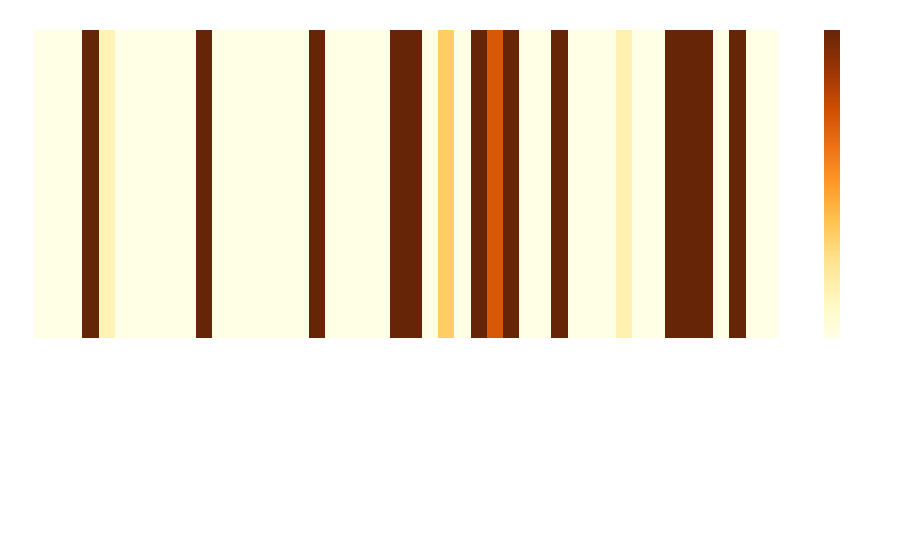

In [17]:
plt.figure(figsize = (12, 4), dpi = 100)
sns.heatmap(test_results, cmap = "YlOrBr", vmin = 0, vmax = 0.0006)
plt.title("t-test p value")
plt.savefig(path + '../figs/t-test_5star.png',bbox_inches = 'tight')
plt.show()

We find that all of the 31/39 features are statistically significant, which is unsurprising given their nature. However as this is unhelpful our analysis we sort the features by lowest p-value.

In [18]:
test_results.T.sort_values('5_star_vs_other').head(10)

,5_star_vs_other
united_states_of_america,4.371200e-95
Drama,1.031922e-91
english_language,1.754005e-85
Horror,5.943461e-72
india,3.866682e-70
World_cinema,1.441300e-66
Short_Film,9.942822e-53
topic_3,3.263781e-50
Documentary,9.457991e-47
Action,1.920714e-28


This already gives us some indication as to which features have a large influence on the rating, however we do not learn anything about the magnitude or the positive/negative nature of the effect. To get this information we evaluate the mean differences on standardized data.

In [19]:
                # 5 star
mean_diff = grouped.mean().iloc[0] - grouped.mean().iloc[1]

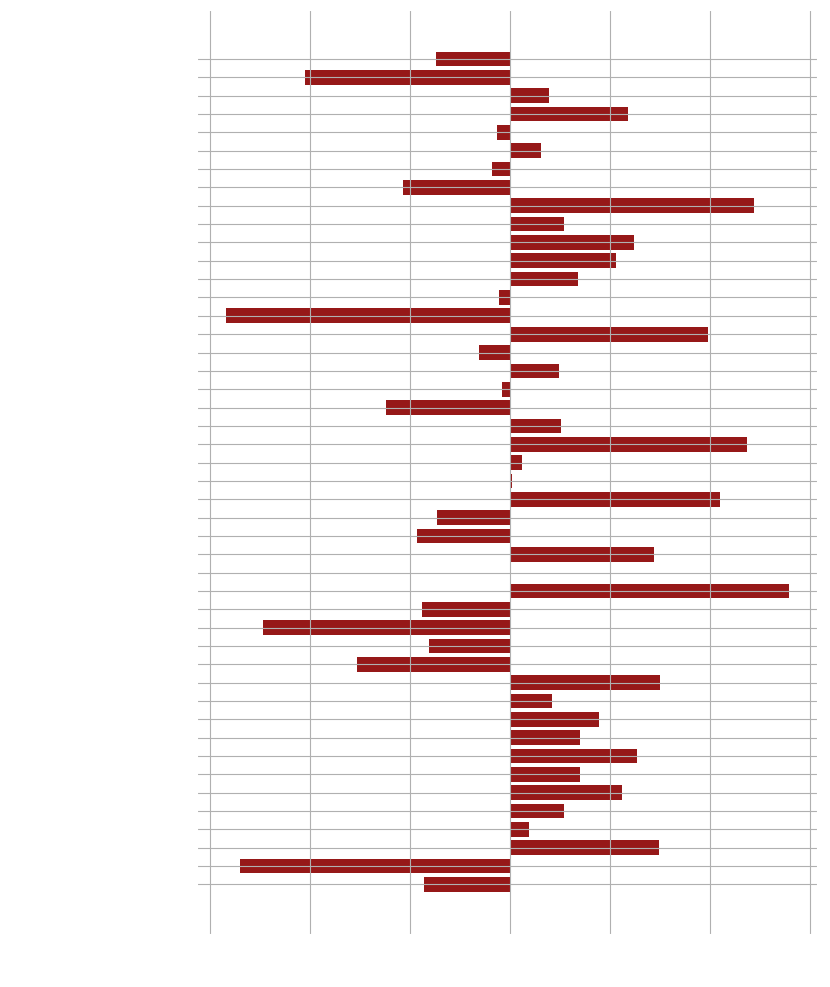

In [20]:
plt.figure(figsize= (8,12), dpi = 100)
plt.barh(range(len(mean_diff)), mean_diff, color = fig_color)
plt.yticks(range(len(mean_diff)), labels = mean_diff.index)
plt.grid()
plt.xlabel([-0.3,0.3])
plt.savefig(path + '../figs/mean_differences_5star.png',bbox_inches = 'tight')
plt.show()

### Side tangent: gender bias
It appears that movies with the highest ratings have a non-negligeable gender bias, i.e. the cast includes a lower proportion of women. To confirm this we compare the bootstrapped confidence intervals of the non-standardized gender proportion data for 5-star and non-5-star movies.

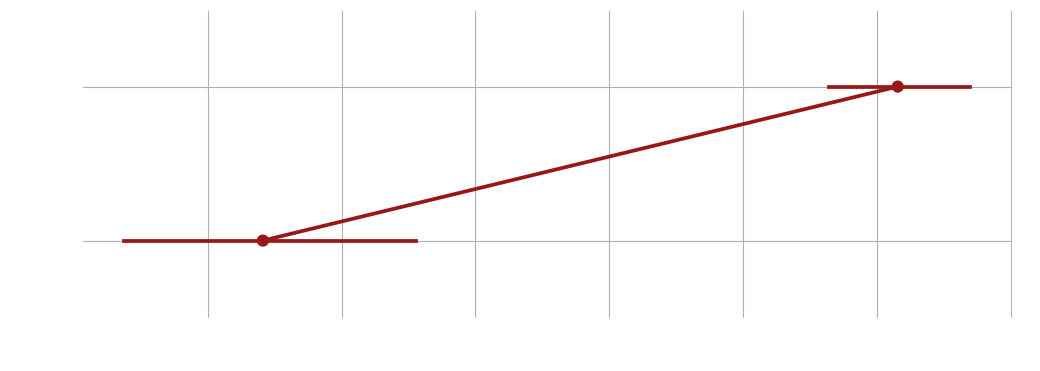

In [21]:
plt.figure(figsize = (12, 4), dpi = 100)
sns.pointplot(data=stat_data, y="rating", x="F_gender", color = fig_color)
plt.savefig(path + '../figs/gender_bias.png',bbox_inches = 'tight')
plt.grid()

There seems to be indeed a noticeable bias of approximately 0.03 in the most critically acclaimed movies.

Let us now find the 10 most helpful and unhelpful features.

In [22]:
mean_diff.sort_values(ascending=False).head(10)

Drama              0.279250
india              0.243610
World_cinema       0.237185
Short_Film         0.210422
Documentary        0.197735
french_language    0.149718
german_language    0.149166
Black_and_white    0.143741
tamil_language     0.126696
france             0.123579
dtype: float64

In [23]:
mean_diff.sort_values(ascending=True).head(10)

united_states_of_america   -0.284412
english_language           -0.269451
Horror                     -0.246807
topic_3                    -0.205178
Action                     -0.152440
Action/Adventure           -0.123443
F_gender                   -0.106692
Comedy                     -0.093425
Thriller                   -0.087721
release_date               -0.085512
dtype: float64

### Effect of language and country of production
As making the movie in english and in the USA seems to be the worst choice possible, let us first examine the effect of language and country of production. As the language and country of production are closely related, we consider them together. The most positively impactful language-country pairs seem to be French-France and Tamil-India, additionally German language seems to be also very positively impactful based on mean differences.

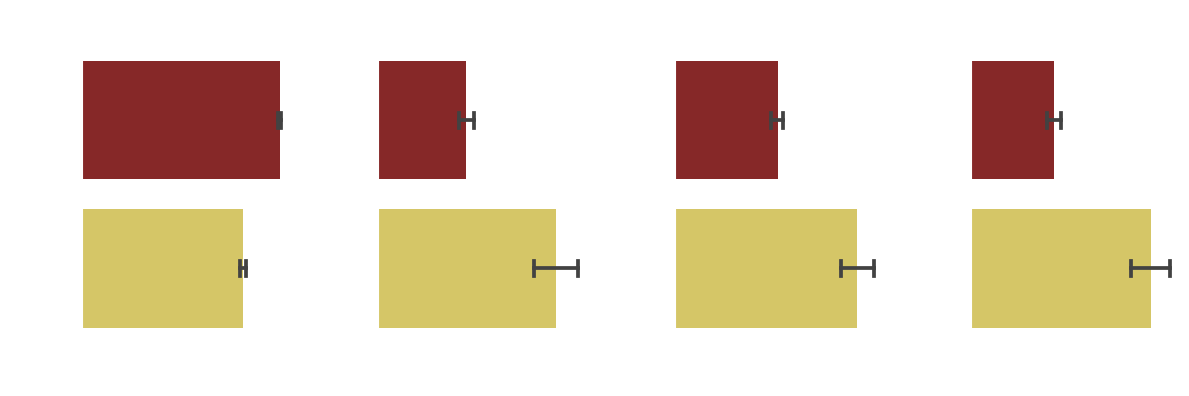

In [29]:
cols = ["english_language", "tamil_language", "french_language", "german_language"]

fig, axs = plt.subplots(1, len(cols), figsize = (12, 4), dpi = 100)

axs = axs.flatten()

for ax, col in zip(axs, cols):
    sns.barplot(ax = ax, data=stat_data, y="rating", x= col, palette = [fig_color,fig_color_1], capsize = 0.1)

plt.suptitle("Language impact on imdb score")
plt.tight_layout()
plt.savefig(path + '../figs/language_impact_imdb.png',bbox_inches = 'tight')
plt.show()

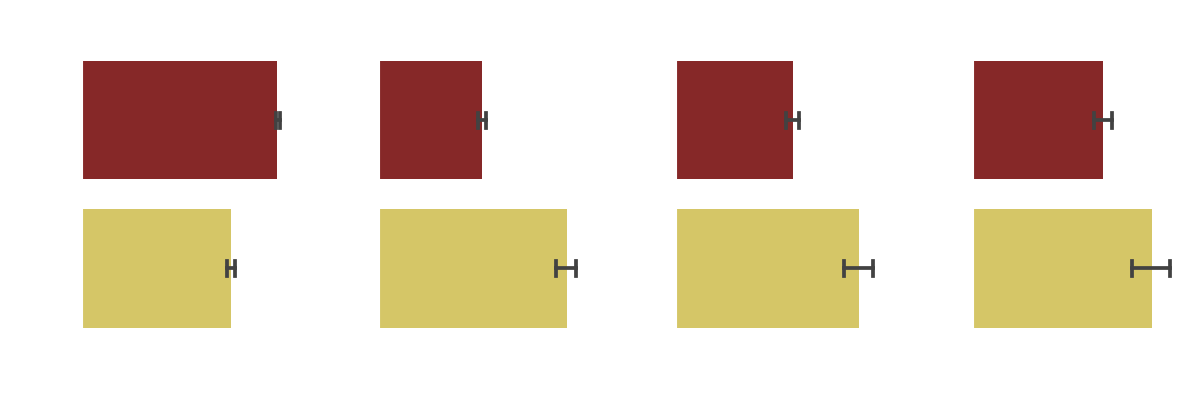

In [33]:
cols = ['united_states_of_america', "india", "france", "germany"]

fig, axs = plt.subplots(1, len(cols), figsize = (12, 4), dpi = 100)

axs = axs.flatten()

for ax, col in zip(axs, cols):
    sns.barplot(ax = ax, data=stat_data, y="rating", x= col, palette = [fig_color,fig_color_1], capsize = 0.1)

plt.suptitle("Country on imdb score")
plt.tight_layout()
plt.savefig(path + '../figs/countries_impact_imdb.png',bbox_inches = 'tight')
plt.show()

Our results confirm that movies made in English and in the USA fare significantly worse in the ratings than Indian movies in Tamil, French movies and German movies.

### Effect of genre
As we wish to make the most IMDB-successful movie possible, we will focus on the 4 most positively correlated genres.

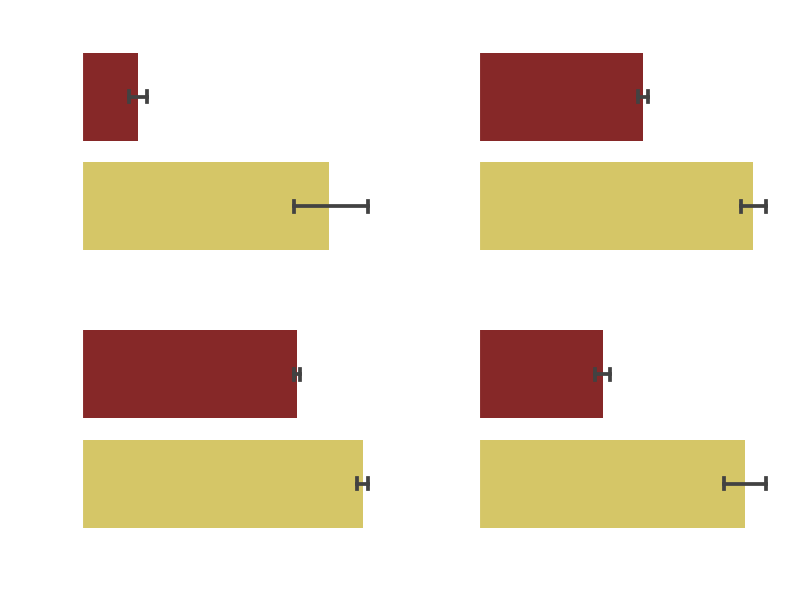

In [26]:
cols = ["Documentary", "World_cinema", "Drama", "Short_Film"]

fig, axs = plt.subplots(2, 2, figsize = (8, 6), dpi = 100)

axs = axs.flatten()

for ax, col in zip(axs, cols):
    sns.barplot(ax = ax, data=stat_data, y="rating", x= col, palette = [fig_color,fig_color_1], capsize = 0.1)

plt.suptitle("Positive impacting genres on imdb score")
plt.tight_layout()
plt.savefig(path + '../figs/positive_genre_impact_imdb.png',bbox_inches = 'tight')
plt.show()

### Effects of topics

We see the effect of our computed `topics` representation of the plot summaries

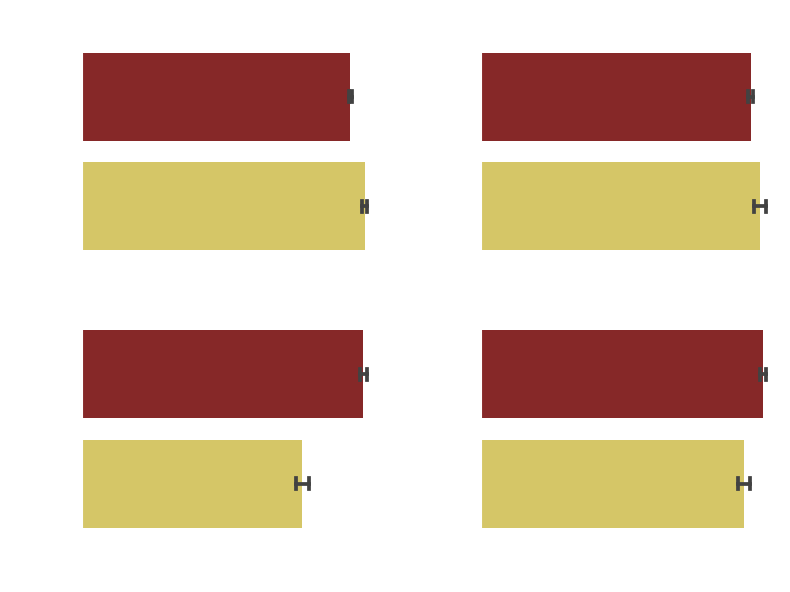

In [27]:
cols = ["topic_1", "topic_2", "topic_3", "topic_4"]


fig, axs = plt.subplots(2, 2, figsize = (8, 6), dpi = 100)

axs = axs.flatten()

for ax, col in zip(axs, cols):
    sns.barplot(ax = ax, data=stat_data, y="rating", x= col, palette = [fig_color,fig_color_1], capsize = 0.1)

plt.suptitle("Topic impact on imdb score")
plt.tight_layout()
plt.savefig(path + '../figs/topics_impact_imdb.png',bbox_inches = 'tight')
plt.show()

### Effects of Factors

We see the effect of our computed `factors` representation of the plot summaries

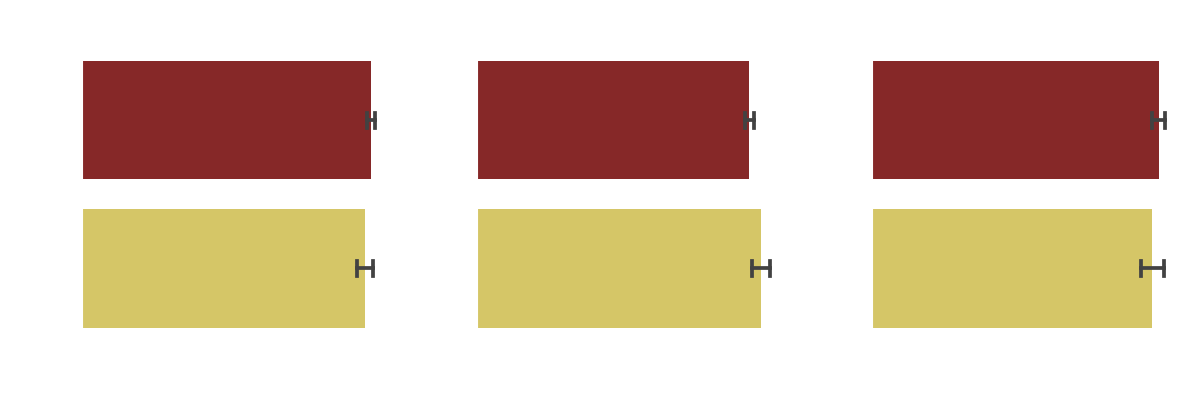

In [28]:
cols = ["factor_1","factor_2","factor_3"]

fig, axs = plt.subplots(1, 3, figsize = (12, 4), dpi = 100)
axs = axs.flatten()

for ax, col in zip(axs, cols):
    sns.barplot(ax = ax, data=stat_data, y="rating", x= col, palette = [fig_color,fig_color_1], capsize = 0.1)

plt.suptitle("Factor impact on imdb score")
plt.tight_layout()
plt.savefig(path + '../figs/factors_impact_imdb.png',bbox_inches = 'tight')
plt.show()

As the confidence intervals are very distinct, we conclude that documentaries, world cinema, dramas and short films perform better in the IMDB.

As well that movies in french and german makes the movies imdb score perform better. Whereas, english language tends to make it worse.

Interestingly enough, movies in whose production is in the USA perform worse in general, and we can assume that most of them if not all of them are in english language. These movies tend to perform worse than movies produced in france or india, the latter perform best.


Regarding topics, we observe than only topic 3 makes a significative difference in imdb score, making it worse. Which makes sense considering that the label we assigned, or explanaiton we found for topic 3 is `low budget action movies`. 

Finally, as expected, factors do not play any particular role in determining movie success.